In [1]:
import random
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from reg_models import get_quant, get_quants
from utils import get_data, get_models_and_traces, reset_traces_and_models

random.seed(2024)
# train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=5000, size_test=2000)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=500, size_test=400)
_, nucr_data = get_data(filepath="processed_data/nucr_runners.csv", size_train=0, size_test=9)

# size_train=2000 - 33min, size_train=2500 - 40min, size_train=5000 - 1h, 20min
# reset_traces_and_models(train)

In [4]:
train

,id,dist,curr_pace,total_pace,finish,age,gender,year
61,262349,5K,4.945598,4.945598,4.800341,30,M,2022
89,262377,5K,4.703669,4.703669,4.739946,36,M,2022
155,262443,5K,4.690432,4.690432,4.649074,29,M,2022
194,262482,5K,4.708098,4.708098,4.609460,33,M,2022
215,262503,5K,5.000000,5.000000,4.578947,25,M,2022
...,...,...,...,...,...,...,...,...
195667,286532,40K,1.431025,2.036556,1.986208,55,M,2022
195734,286599,40K,1.868460,1.966085,1.962102,50,M,2022
195737,286602,40K,2.060157,1.957139,1.961919,60,F,2022
195806,286671,40K,1.728310,1.941371,1.936794,29,F,2022


In [11]:
marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
[[model1, model2], [trace1, trace2]] = get_models_and_traces(
        # model1 = "traces3/linear_model1.nc", trace1 = "traces3/linear_trace1.nc", model2 = "traces3/linear_model2.nc", trace2 = "traces3/linear_trace2.nc",
)

y_true = (42195 / 60) / test["finish"]
test["extrap"] = ((42195 / 60) / test["total_pace"]) - y_true
b1 = model1.prediction(test, trace1)
b2 = model2.prediction(test, trace2)

test["bayes1"] = np.median(b1, axis=1) - y_true  # b1.mean(axis=1) - y_true
test["bayes2"] = np.median(b2, axis=1) - y_true  # b2.mean(axis=1) - y_true

map1 = {v:k for k, v in enumerate(marks)}
test["dist2"] = test["dist"].apply(lambda x: map1[x])
train["dist2"] = train["dist"].apply(lambda x: map1[x])

q1 = get_quant(train, test, formula="finish ~ total_pace + dist2")
q2 = get_quant(train, test, formula="finish ~ total_pace + curr_pace + dist2")

test["quant1"] = q1 - y_true
test["quant2"] = q2 - y_true

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
Sampling: [y]


Sampling: [y]


         extrap     bayes1     bayes2     quant1     quant2
dist                                                       
5K    18.598910  14.866293  15.029876  15.141850  15.248756
10K   17.199299  12.827209  12.966711  12.532611  12.315635
15K   15.875157  11.496969  10.783298  11.026157  10.702285
20K   13.521650   9.688783   7.736763   9.189377   8.479083
25K   10.927477   7.570491   6.889607   7.120122   6.282873
30K    7.399381   5.682410   4.669469   5.222010   4.401434
35K    3.974610   3.579373   2.244191   3.565046   2.836172
40K    1.175351   1.126935   7.766952   1.328664   2.117415


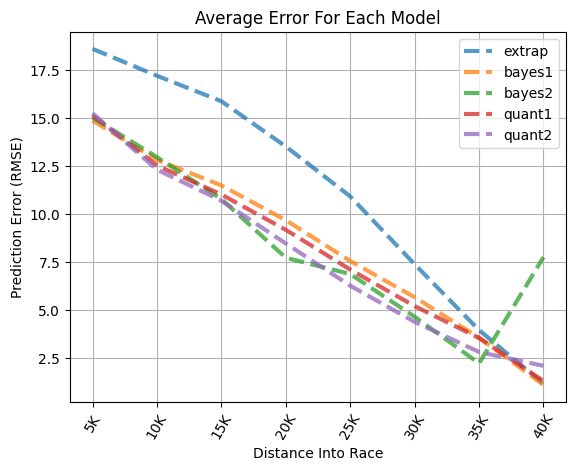

In [12]:
labels = ["extrap", "bayes1", "bayes2", "quant1", "quant2"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table = test.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table)
table.plot(label=table.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
plt.savefig("analysis/all_errors.png", bbox_inches="tight")

In [13]:
def add_intervals_to_test(test_data, b1, b2, q1, q2):
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / test_data["finish"]
        b11, b12 = np.percentile(b1, [lower, upper], axis=1)
        test_data[f"bayes1-lower{conf}"] = b11
        test_data[f"bayes1-upper{conf}"] = b12
        test_data[f"bayes1-size{conf}"] = b12 - b11
        test_data[f"bayes1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(b2, [lower, upper], axis=1)
        test_data[f"bayes2-lower{conf}"] = b21
        test_data[f"bayes2-upper{conf}"] = b22
        test_data[f"bayes2-size{conf}"] = b22 - b21
        test_data[f"bayes2-in{conf}"] = (test_true < b22) & (test_true > b21)

        q11, q12 = get_quants(train, test, formula="finish ~ total_pace + dist", quantiles=[lower, upper])
        test_data[f"quant1-lower{conf}"] = q11
        test_data[f"quant1-upper{conf}"] = q12
        test_data[f"quant1-size{conf}"] = q12 - q11
        test_data[f"quant1-in{conf}"] = (test_true < q12) & (test_true > q11)

        q21, q22 = get_quants(train, test, formula="finish ~ total_pace + curr_pace + dist", quantiles=[lower, upper])
        test_data[f"quant2-lower{conf}"] = q21
        test_data[f"quant2-upper{conf}"] = q22
        test_data[f"quant2-size{conf}"] = q22 - q21
        test_data[f"quant2-in{conf}"] = (test_true < q22) & (test_true > q21)

    return test_data

test = add_intervals_to_test(test, b1, b2, q1, q2)

<Figure size 4000x4000 with 0 Axes>

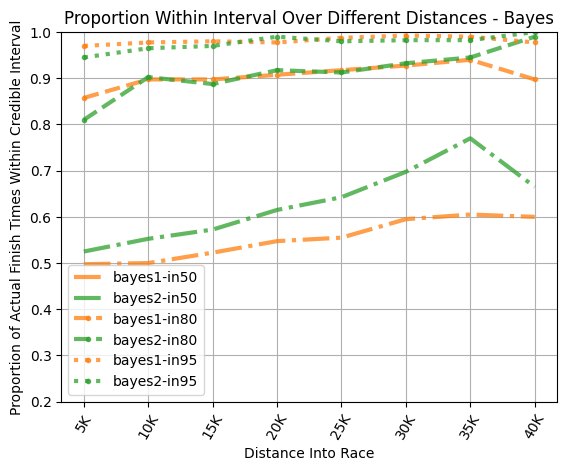

In [14]:
colors = ['C1', 'C2'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-in{conf}", f"bayes2-in{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")

<Figure size 4000x4000 with 0 Axes>

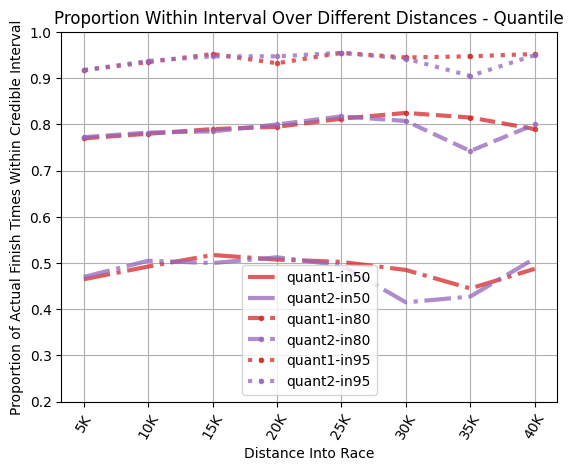

In [15]:
colors = ['C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"quant1-in{conf}", f"quant2-in{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
plt.ylim(0.2, 1) 

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.title("Proportion Within Interval Over Different Distances - Quantile")
plt.grid(True)
plt.legend()
plt.savefig("analysis/interval_check_quant.png", bbox_inches="tight")

<Figure size 3000x2000 with 0 Axes>

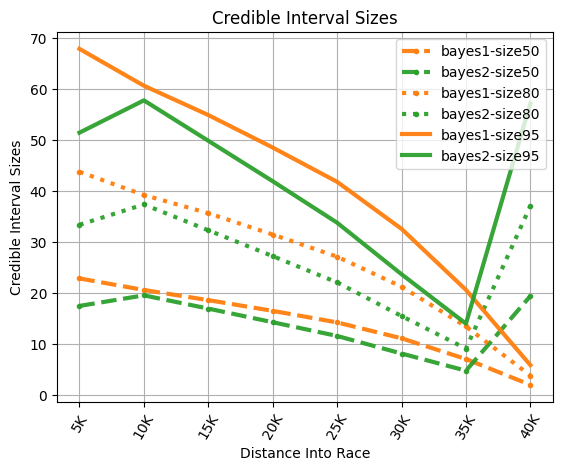

In [16]:
colors = ['C1', 'C2'] * 3
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] * 2
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-size{conf}", f"bayes2-size{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
plt.savefig("analysis/interval_sizes_bayes.png", bbox_inches="tight")


<Figure size 3000x2000 with 0 Axes>

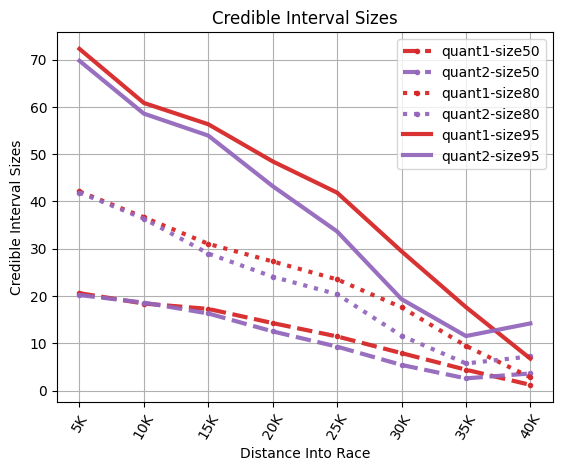

In [17]:
colors = ['C3', 'C4'] * 3
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] * 2
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"quant1-size{conf}", f"quant2-size{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
plt.savefig("analysis/interval_sizes_quant.png", bbox_inches="tight")

In [18]:
# az.summary(trace1)
# # az.plot_trace(trace2)

In [3]:
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=286777,train_tup=(0, 2023), size_test=400)

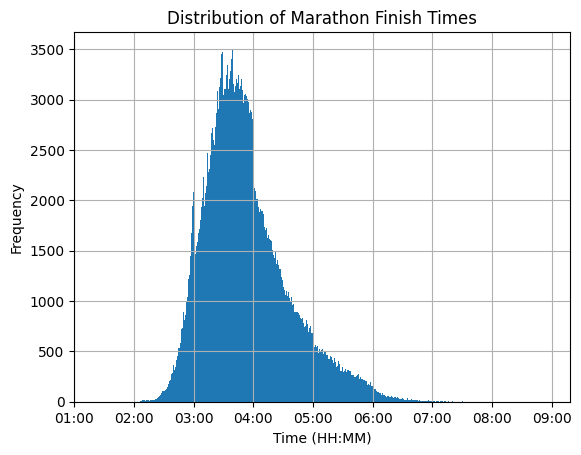

In [21]:
from utils import binning, int_to_str_time#, Union
ticks = (60, 120, 180, 240, 300, 360, 420, 480, 540)
minutes_dist = ((42195 / 60) / train[train["dist"] == "5K"]["finish"]) // 1
bins = binning(minutes_dist)
minutes_dist.hist(bins=bins)
labels = [int_to_str_time(t) for t in ticks]
plt.xticks(ticks, labels=labels)
plt.xlabel(f"Time (HH:MM)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Marathon Finish Times")
plt.savefig(f"analysis/plot_dist2.png")

In [4]:
table1 = train[train["dist"].isin(["10K", "20K", "30K"])]
# table1 = train[train["dist"].isin(["5K", "15K", "25K", "35K"])]
# table1 = train[train["dist"].isin(["10K", "30K"])]
table1[["total_pace", "finish"]] = table1[["total_pace", "finish"]].apply(lambda x: (42195 / 60) / x)
# mapping = {"10K": "red", "20K": "green", "30K": "blue"}
# table1['col'] = table1["dist"].apply(lambda x: mapping[x])
table1

/var/folders/fg/rrlp0jyd0yx58b9sdy3mnbkm0000gn/T/ipykernel_2666/2139619495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1[["total_pace", "finish"]] = table1[["total_pace", "finish"]].apply(lambda x: (42195 / 60) / x)


,id,dist,curr_pace,total_pace,finish,age,gender,year
286777,0,10K,5.586592,124.404925,128.700000,28,M,2009
286778,1,10K,5.580357,124.475250,129.533333,30,M,2009
286779,2,10K,5.586592,124.404925,129.666667,26,M,2009
286780,3,10K,5.586592,124.404925,129.816667,27,M,2009
286781,4,10K,5.586592,124.404925,130.100000,20,M,2009
...,...,...,...,...,...,...,...,...
1720657,286772,30K,1.435544,400.219575,415.816667,61,M,2022
1720658,286773,30K,1.537515,386.084250,416.583333,58,M,2022
1720659,286774,30K,1.488982,394.288833,418.200000,51,M,2022
1720660,286775,30K,1.219215,416.488092,418.833333,61,M,2022


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

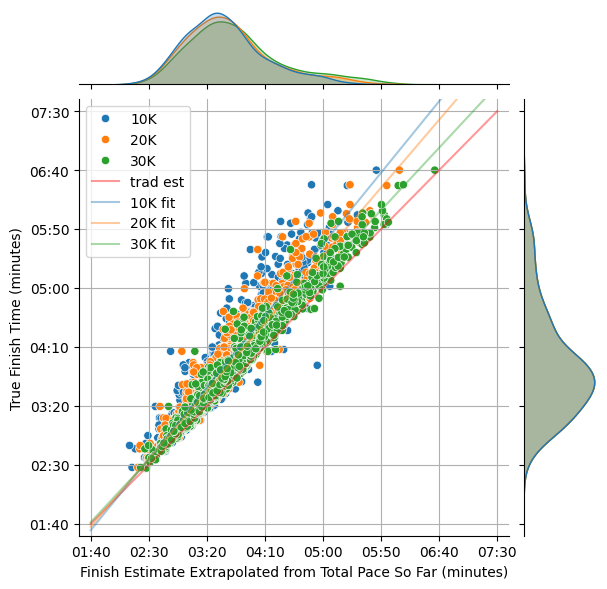

In [27]:
from utils import int_to_str_time
np.random.seed(2024)
train_ids = np.random.choice(np.array(list(set(table1["id"]))), 1000, replace=False)
table2 = table1[table1["id"].isin(train_ids)]

sns.jointplot(data=table2, x="total_pace", y="finish", hue="dist")
plt.plot([100, 450], [100, 450], color="red", label='trad est', alpha=0.4)
plt.xlabel("Finish Estimate Extrapolated from Total Pace So Far (minutes)")
plt.ylabel("True Finish Time (minutes)")

ticks = (100, 150, 200, 250, 300, 350, 400, 450)
labels = [int_to_str_time(t) for t in ticks]
plt.xticks(ticks, labels=labels)
plt.yticks(ticks, labels=labels)


for dist, color in [("10K", "blue"), ("20K", "orange"), ("30K", "green")]:
    small_data = table2[table2["dist"] == dist]#[["total_pace", "finish"]]
    m, b = np.polyfit(small_data["total_pace"], small_data["finish"], 1)
    x = np.array([100, 450])
    plt.plot(x, m*x + b, alpha=0.4, label=f"{dist} fit")

plt.ylim(90, 460)
plt.xlim(90, 460)
# plt.title("Comparing Extrapolated Estimates to True Finish At Different Stages of Race")
plt.grid()
plt.legend()
plt.savefig("analysis/data_scatter.png", bbox_inches="tight")

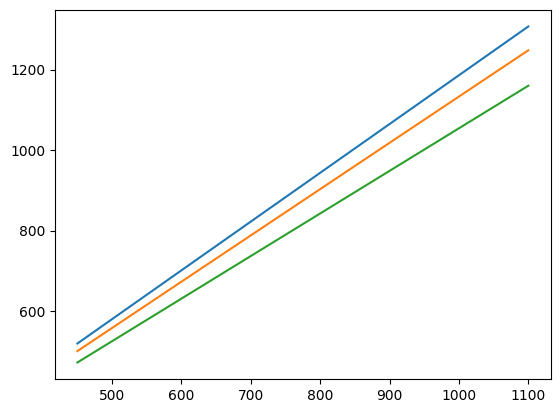

In [19]:

for dist, color in [("10K", "blue"), ("20K", "orange"), ("30K", "green")]:
    small_data = table2[table2["dist"] == dist]#[["total_pace", "finish"]]
    m, b = np.polyfit(small_data["total_pace"], small_data["finish"], 1)
    x = np.array([1100, 450])
    plt.plot(x, m*x + b)

In [16]:
m, b = np.polyfit(small_data["total_pace"], small_data["finish"], 1)

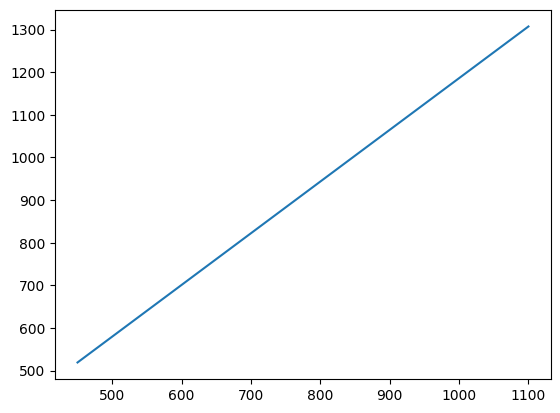

In [18]:
x = np.array([1100, 450])
plt.plot(x, m*x + b)